# 分类

## MNIST

In [1]:
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original')

d:\python3.5.3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
d:\python3.5.3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

sklearn加载的数据集通常具有类似的字典结构

- DESCR键：描述数据集
- data键：包含一个数组，每个实例为一行，每个特征为一列
- target键：包含一个带有标记的数组

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt

In [13]:
import matplotlib as mpl

In [10]:
some_digit = X[36000]

In [11]:
some_digit_image = some_digit.reshape(28, 28)

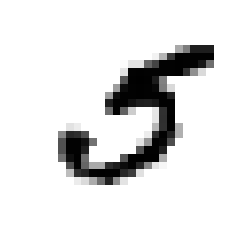

In [14]:
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [15]:
y[36000]

5.0

- 划分训练集和测试集

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

- 对数据进行洗牌

In [17]:
import numpy as np

In [18]:
shuffle_index = np.random.permutation(60000)

In [19]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练一个二元分类器

- 先简化问题，只尝试识别一个数字——5

In [20]:
y_train_5 = (y_train == 5)

In [21]:
y_train_5

array([False, False,  True, ..., False, False, False])

In [22]:
y_test = (y_test == 5)

In [23]:
from sklearn.linear_model import SGDClassifier

In [24]:
sgd_clf = SGDClassifier(random_state=42)

In [35]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

现在可以用它来检测数字5的图像了

In [37]:
sgd_clf.predict([X_train[2]])

array([ True])

## 性能考核

### 使用交叉验证测量精度

- 自行实施交叉验证

In [38]:
from sklearn.model_selection import StratifiedKFold

In [39]:
from sklearn.base import clone

In [40]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [41]:
for train_index, test_idnex in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_idnex]
    y_test_fold = y_train_5[test_idnex]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96685
0.93435
0.96325


- 现在用cross_val_score()函数来评估SGDClassifier模型

In [42]:
from sklearn.model_selection import cross_val_score

In [43]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96685, 0.93435, 0.96325])

- 所有的准确率都这么高吗？我们来看一个很蠢的分类器，它将每张图都分类成“非5”

In [44]:
from sklearn.base import BaseEstimator

In [45]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [46]:
never_5_clf = Never5Classifier()

In [47]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91075, 0.91155, 0.90665])

- 这说明准确率通常无法成为分类器的首要性能指标，特别是当你处理偏斜数据集的时候。

### 混淆矩阵

- 评估分类器性能的更好方法是混淆矩阵。

In [48]:
from sklearn.model_selection import cross_val_predict

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [50]:
y_train_pred

array([False, False,  True, ..., False, False, False])

In [51]:
from sklearn.metrics import confusion_matrix

In [52]:
confusion_matrix(y_train_5, y_train_pred)

array([[52606,  1973],
       [  738,  4683]], dtype=int64)

### 精度和召回率

In [53]:
from sklearn.metrics import precision_score, recall_score

- 精度：预测positive里面，预测正确了多少

In [55]:
precision_score(y_train_5, y_train_pred)

0.7035757211538461

- 召回：实际positive里面，预测正确了多少

In [56]:
recall_score(y_train_5, y_train_pred)

0.8638627559490869

- F1分数：精度和召回率的谐波平均值

谐波平均值会给予较低的值更高的权重
F1分数对那些具有相近的精度和召回率的分类器更为有利。

In [57]:
from sklearn.metrics import f1_score

In [58]:
f1_score(y_train_5, y_train_pred)

0.7755237227788359

### 精度/召回率权衡

In [59]:
some_digit

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  86, 131, 225, 225, 225,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [60]:
y_scores = sgd_clf.decision_function([some_digit])

In [61]:
y_scores

array([-531.81431086])

In [65]:
threshold = -1000

In [66]:
y_some_digit_pred = (y_scores > threshold)

In [67]:
y_some_digit_pred

array([ True])

In [68]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [69]:
y_scores

array([-24763.9751405 , -11923.64506077,   9368.04706416, ...,
       -16112.83982555,  -3100.28339405, -22267.13470421])

In [70]:
from sklearn.metrics import precision_recall_curve

In [71]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [72]:
thresholds

array([-103147.09002614, -100938.63943898,  -99910.09686304, ...,
         29828.30959505,   30754.94464061,   34385.78413926])

In [73]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])

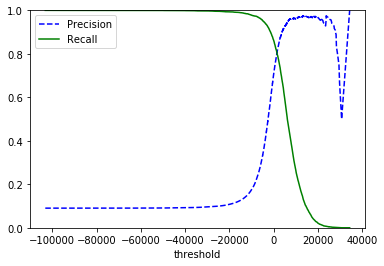

In [75]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [76]:
y_scores

array([-24763.9751405 , -11923.64506077,   9368.04706416, ...,
       -16112.83982555,  -3100.28339405, -22267.13470421])

In [80]:
y_train_pred_90 = (y_scores > 7000)

In [81]:
y_train_pred_90

array([False, False,  True, ..., False, False, False])

In [82]:
precision_score(y_train_5, y_train_pred_90)

0.955824863174355

In [83]:
recall_score(y_train_5, y_train_pred_90)

0.45102379634753736

### ROC曲线

- 受试者工作特征曲线

In [84]:
from sklearn.metrics import roc_curve

In [85]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [87]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

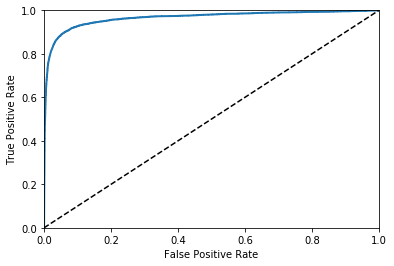

In [88]:
plot_roc_curve(fpr, tpr)
plt.show()

- 有一种比较分类器的方法是测量曲线下面积（AUC）
- 完美的分类器的ROC AUC等于1，而纯随机分类器的ROC AUC等于0.5。

In [89]:
from sklearn.metrics import roc_auc_score

In [90]:
roc_auc_score(y_train_5, y_scores)

0.9655431576923241

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
forest_clf = RandomForestClassifier(random_state=42)

In [93]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

d:\python3.5.3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
d:\python3.5.3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
d:\python3.5.3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [94]:
y_probas_forest

array([[1. , 0. ],
       [1. , 0. ],
       [0.1, 0.9],
       ...,
       [1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ]])

- 但是要绘制ROC曲线，需要的时分数值而不是概率大小。一个简单的解决方案是：**直接使用正类的概率作为分数值**

In [96]:
y_scores_forest = y_probas_forest[:, 1]

In [97]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

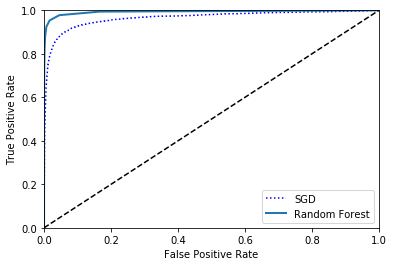

In [99]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [100]:
roc_auc_score(y_train_5, y_scores_forest)

0.9933219333652814

In [102]:
y_sc_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

d:\python3.5.3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
d:\python3.5.3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
d:\python3.5.3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [103]:
y_sc_forest

array([False, False,  True, ..., False, False, False])

In [104]:
precision_score(y_train_5, y_sc_forest)

0.982514386896857

In [105]:
recall_score(y_train_5, y_sc_forest)

0.8188526102195167

## 多类别分类器

In [106]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [108]:
sgd_clf.predict([some_digit])

array([5.])

In [112]:
some_digits_scores = sgd_clf.decision_function([some_digit])

In [113]:
some_digits_scores

array([[-16109.98574617, -20287.04664099,  -5362.4596988 ,
         -4418.89077241, -15172.0507476 ,   2560.87132584,
        -28940.58092618, -14492.48090507, -10166.84495831,
        -14741.3011392 ]])

In [114]:
np.argmax(some_digits_scores)

5

In [115]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [116]:
sgd_clf.classes_[np.argmax(some_digits_scores)]

5.0

In [117]:
from sklearn.multiclass import OneVsOneClassifier

In [118]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

In [119]:
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [120]:
ovo_clf.predict([some_digit])

array([5.])

In [121]:
len(ovo_clf.estimators_)

45

In [122]:
forest_clf.fit(X_train, y_train)

d:\python3.5.3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [123]:
forest_clf.predict([some_digit])

array([5.])

- 这里sklearn不必用OvA或者OvO了，因为随机森林分类器直接就可以将实例分为多个类别。

In [124]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0.1, 0. ]])

In [125]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8855229 , 0.85464273, 0.8746812 ])

- 对输入进行简单的缩放

In [126]:
from sklearn.preprocessing import StandardScaler

In [127]:
scaler = StandardScaler()

In [128]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [129]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90256949, 0.89784489, 0.89973496])

## 错误分析

In [131]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [132]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [133]:
conf_mx

array([[5586,    0,   13,    7,    8,   36,   32,    6,  234,    1],
       [   1, 6414,   44,   24,    3,   41,    4,    6,  194,   11],
       [  22,   25, 5253,   89,   71,   22,   62,   36,  370,    8],
       [  28,   22,  106, 5256,    2,  182,   26,   41,  404,   64],
       [  11,   14,   42,   10, 5222,    9,   36,   20,  335,  143],
       [  30,   15,   26,  162,   54, 4435,   75,   17,  551,   56],
       [  29,   15,   48,    0,   41,   84, 5566,    3,  132,    0],
       [  20,   13,   51,   20,   51,   11,    5, 5714,  190,  190],
       [  16,   68,   44,   95,    3,  109,   28,    8, 5437,   43],
       [  26,   23,   25,   60,  114,   36,    1,  172,  372, 5120]],
      dtype=int64)

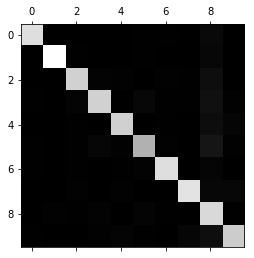

In [134]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

- 混淆矩阵看起来很不错，因为大多数图片都在主对角线上，这说明它们被正确分类。

- 改为比较错误率，而不是绝对值

In [135]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

In [136]:
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

In [137]:
norm_conf_mx = conf_mx / row_sums

In [138]:
norm_conf_mx

array([[9.43103157e-01, 0.00000000e+00, 2.19483370e-03, 1.18183353e-03,
        1.35066689e-03, 6.07800101e-03, 5.40266757e-03, 1.01300017e-03,
        3.95070066e-02, 1.68833361e-04],
       [1.48323939e-04, 9.51349748e-01, 6.52625334e-03, 3.55977455e-03,
        4.44971818e-04, 6.08128152e-03, 5.93295758e-04, 8.89943637e-04,
        2.87748443e-02, 1.63156333e-03],
       [3.69251427e-03, 4.19603894e-03, 8.81671702e-01, 1.49378986e-02,
        1.19167506e-02, 3.69251427e-03, 1.04061766e-02, 6.04229607e-03,
        6.21013763e-02, 1.34273246e-03],
       [4.56695482e-03, 3.58832164e-03, 1.72891861e-02, 8.57282662e-01,
        3.26211059e-04, 2.96852063e-02, 4.24074376e-03, 6.68732670e-03,
        6.58946338e-02, 1.04387539e-02],
       [1.88291681e-03, 2.39643958e-03, 7.18931873e-03, 1.71174255e-03,
        8.93871962e-01, 1.54056830e-03, 6.16227319e-03, 3.42348511e-03,
        5.73433756e-02, 2.44779185e-02],
       [5.53403431e-03, 2.76701716e-03, 4.79616307e-03, 2.98837853e-02,
   

- 用0填充对角线，只保留错误，重新绘制结果。

In [139]:
np.fill_diagonal(norm_conf_mx, 0)

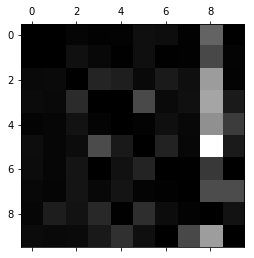

In [140]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 我更喜欢的混淆矩阵

In [142]:
import seaborn as sns

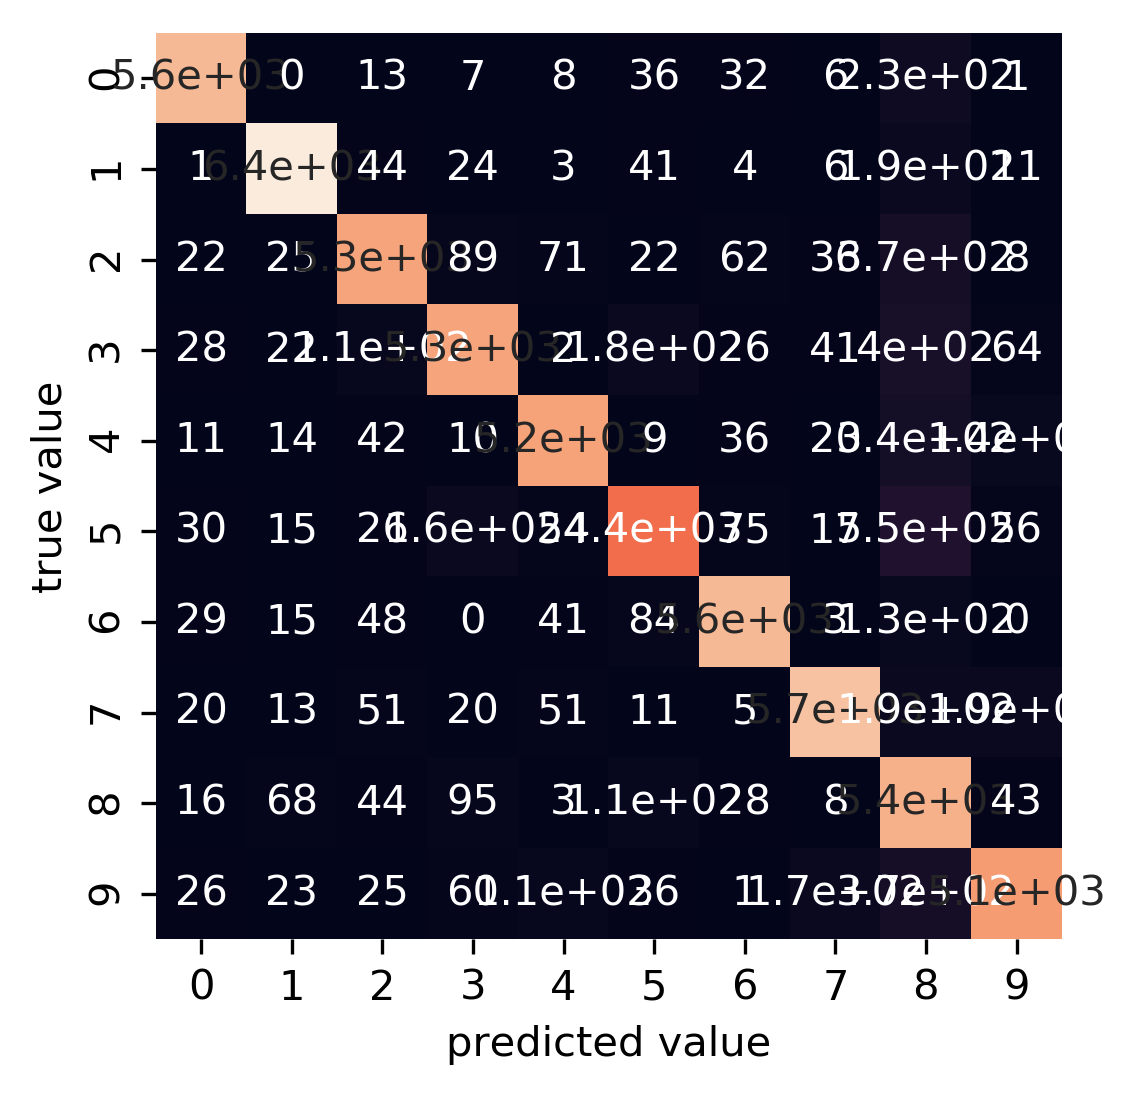

In [145]:
fig, ax = plt.subplots(dpi=300)
with sns.axes_style('white'):
    sns.heatmap(conf_mx, square=True, annot=True, cbar=False, ax=ax)
    plt.xlabel('predicted value')
    plt.ylabel('true value')

## 多标签分类

In [152]:
from sklearn.neighbors import KNeighborsClassifier

In [153]:
y_train_large = (y_train >= 7)

In [154]:
y_train_odd = (y_train % 2 == 1)

In [155]:
y_multilabel = np.c_[y_train_large, y_train_odd]

In [156]:
y_multilabel

array([[False, False],
       [ True,  True],
       [False,  True],
       ...,
       [False, False],
       [ True,  True],
       [ True,  True]])

In [157]:
y_train_large

array([False,  True, False, ..., False,  True,  True])

In [158]:
knn_clf = KNeighborsClassifier()

In [159]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [160]:
knn_clf.predict([some_digit])

array([[False,  True]])

f1_score多标签分类器

In [164]:
y_train

array([2., 9., 5., ..., 4., 7., 9.])

In [165]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

In [166]:
f1_score(y_train, y_train_knn_pred, average="macro")

0.9682338822846033

## 多输出分类

In [167]:
import numpy as np

In [169]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100 ,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

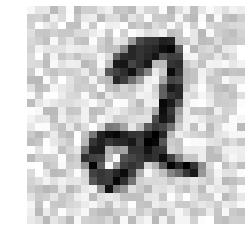

In [173]:
plt.imshow(X_train_mod[0].reshape(28, 28), cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

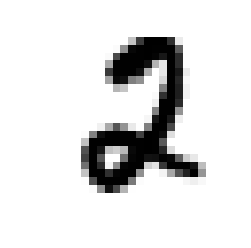

In [174]:
plt.imshow(y_train_mod[0].reshape(28, 28), cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [175]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [176]:
clean_digit = knn_clf.predict([X_test_mod[0]])

In [177]:
clean_digit

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  50, 104, 255,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  53, 253, 253,
        253, 107,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

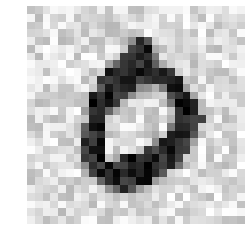

In [179]:
plt.imshow(X_test_mod[0].reshape(28, 28), cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

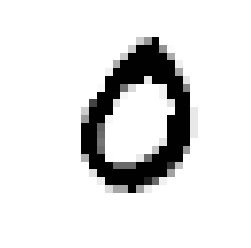

In [180]:
plt.imshow(clean_digit.reshape(28, 28), cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()